In [2]:
# multi_mgr_for_one_stock.py
from pathlib import Path
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



from utils.io import json_data_to_df
from utils.prompt_builder import build_single_prompt
from utils.api import get_response
from utils.pred_with_history import pipeline
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from pathlib import Path



In [ ]:
# ---------- 小工具 ----------


def _standardize_quarter_start(dt_ser: pd.Series) -> pd.Series:
    """把日期标准化到季度首，便于对齐绘图/聚合。"""
    s = pd.to_datetime(dt_ser, errors="coerce")
    return s.dt.to_period("Q").dt.asfreq("Q", "start").dt.to_timestamp()

def eligible_mgrnos_for_permno(
    df: pd.DataFrame,
    permno: int,
    start_date: str = None,
    end_date: str = None,
    min_pairs: int = 1,
) -> list[int]:
    """
    找到在给定时间窗内、对该 permno 至少有 (t-1, t) 一对样本的 mgrno（即 len>=2）。
    """
    d = df[df["permno"] == permno].copy()
    d["fdate"] = pd.to_datetime(d["fdate"], errors="coerce")
    if start_date:
        d = d[d["fdate"] >= pd.to_datetime(start_date)]
    if end_date:
        d = d[d["fdate"] <= pd.to_datetime(end_date)]

    # 每个 mgrno 在该股票上的样本数
    cnt = (d.drop_duplicates(["mgrno","fdate"])
             .groupby("mgrno")["fdate"].nunique())
    elig = cnt[cnt >= (min_pairs + 1)].index.tolist()  # 至少 2 个季度 → 1 对 (t-1,t)
    return sorted(elig)

def predict_stock_all_investors(df, permno, start_date, end_date,
                                call_fn=get_response, inv_type="Banks",
                                max_mgr=None, plot=True):
    # 1. 找出所有合格 mgrno
    mgr_list = eligible_mgrnos_for_permno(df, permno, start_date, end_date, min_pairs=1)
    if max_mgr is not None:
        mgr_list = mgr_list[:max_mgr]
    if not mgr_list:
        raise RuntimeError(f"No eligible managers found for permno={permno}.")

    # 2. 跑 pipeline
    all_eval = []
    for mgrno in mgr_list:
        eval_df, metrics, preds, prompts = pipeline(
            df, mgrno, permno, start_date, end_date,
            call_fn, inv_type, plot=False  # 单个投资人不画图
        )
        eval_df["mgrno"] = mgrno
        all_eval.append(eval_df)

    all_eval_df = pd.concat(all_eval, ignore_index=True)

    # 3. 聚合预测（求和）
    agg_pred = (all_eval_df.groupby("target_date_x", as_index=False)["y_pred"].sum()
                .rename(columns={"y_pred":"Hsum_pred"}))

    # 4. 真值（y_true）
    truth = (all_eval_df.groupby("target_date_x", as_index=False)["y_true"].first()
             .rename(columns={"y_true":"Hsum_true"}))

    agg = pd.merge(agg_pred, truth, on="target_date_x", how="inner")

    # 5. 画图
    if plot:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(agg["target_date_x"], agg["Hsum_true"], marker="o", label="True total holding")
        ax.plot(agg["target_date_x"], agg["Hsum_pred"], marker="o", label="Pred total holding (sum over mgr)")
        ax.set_title(f"Total holdings for permno={permno}")
        ax.set_xlabel("Quarter")
        ax.set_ylabel("Total holding")
        ax.grid(True)
        ax.legend()
        plt.show()

    return agg, all_eval_df, mgr_list




Querying model: 100%|██████████| 88/88 [05:11<00:00,  3.53s/it]


NameError: name 'ZoneInfo' is not defined

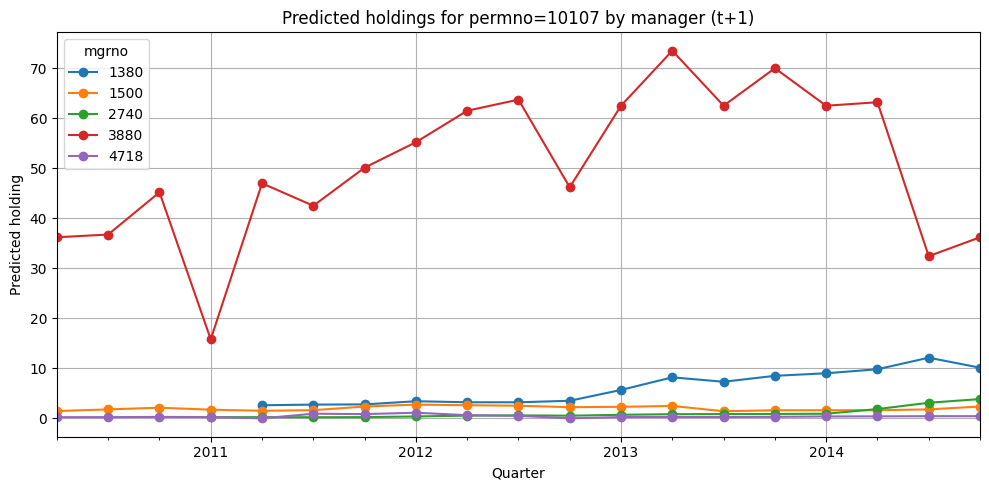

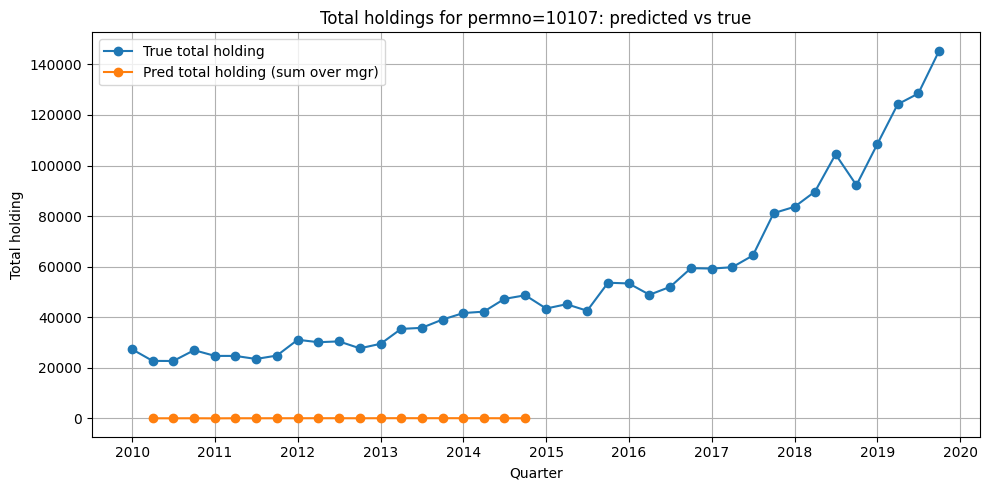

In [ ]:
df = json_data_to_df("banks.json")   # 或者写 "Banks"

agg, all_eval_df, mgr_list = predict_stock_all_investors(
    df=df,
    permno=10107,                  # 股票id
    start_date="2010-01-01",       # 起始时间
    end_date="2012-10-01",         # 结束时间
    call_fn=get_response,          # 你已有的API调用函数
    inv_type="banks",              # 投资人角色
    max_mgr=3,                    # 可选：限制最多跑前10个投资人
    plot=True                      # 是否画总持仓对比图
)